In [31]:
import pandas as pd
import io
import requests
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose

ModuleNotFoundError: No module named 'statsmodels'

In [3]:
columns = ["Year", "Day", "Hour", "WIND Bx_gse, nT", "WIND By_gse, nT" , "WIND Bz_gse, nT"]

file_path = "data/WIND/readings_WIND.lst"
df = pd.read_csv(file_path, sep = "\s+", header=None, names= columns)
df.head()

,Year,Day,Hour,"WIND Bx_gse, nT","WIND By_gse, nT","WIND Bz_gse, nT"
0,1995,1,0,-0.6,3.2,-2.1
1,1995,1,1,-0.9,2.4,-1.3
2,1995,1,2,0.5,1.8,-0.4
3,1995,1,3,-3.2,2.5,0.3
4,1995,1,4,-4.3,2.1,0.3


In [4]:
# merge Year Day hour into one column
df["Date-Time"] = pd.to_datetime(df[["Year", "Day", "Hour"]].astype(str).agg('-'.join, axis=1), format="%Y-%j-%H")
df.set_index('Date-Time', inplace=True)
df.head()

,Year,Day,Hour,"WIND Bx_gse, nT","WIND By_gse, nT","WIND Bz_gse, nT"
Date-Time,,,,,,
1995-01-01 00:00:00,1995,1,0,-0.6,3.2,-2.1
1995-01-01 01:00:00,1995,1,1,-0.9,2.4,-1.3
1995-01-01 02:00:00,1995,1,2,0.5,1.8,-0.4
1995-01-01 03:00:00,1995,1,3,-3.2,2.5,0.3
1995-01-01 04:00:00,1995,1,4,-4.3,2.1,0.3


In [8]:
# Remove all 999.99, replace with NaN
df.loc[df["WIND Bx_gse, nT"] == 999.9, "WIND Bx_gse, nT"] = None
df.loc[df["WIND By_gse, nT"] == 999.9, "WIND By_gse, nT"] = None
df.loc[df["WIND Bz_gse, nT"] == 999.9, "WIND Bz_gse, nT"] = None

df.head()

,Year,Day,Hour,"WIND Bx_gse, nT","WIND By_gse, nT","WIND Bz_gse, nT"
Date-Time,,,,,,
1995-01-01 00:00:00,1995,1,0,-0.6,3.2,-2.1
1995-01-01 01:00:00,1995,1,1,-0.9,2.4,-1.3
1995-01-01 02:00:00,1995,1,2,0.5,1.8,-0.4
1995-01-01 03:00:00,1995,1,3,-3.2,2.5,0.3
1995-01-01 04:00:00,1995,1,4,-4.3,2.1,0.3


In [10]:
imp_cols=["WIND Bx_gse, nT", "WIND By_gse, nT", "WIND Bz_gse, nT"]
for col in imp_cols:
    nan_count = df[col].isna().sum()
    print(f"{col} has Nan: {nan_count} / {len(df[col])}")


WIND Bx_gse, nT has Nan: 12932 / 250920
WIND By_gse, nT has Nan: 12932 / 250920
WIND Bz_gse, nT has Nan: 12932 / 250920


In [13]:
# Dealing w Nan ideas
#1) replace w zero
df['WIND Bz_gse, nT'].fillna(0, inplace=True)

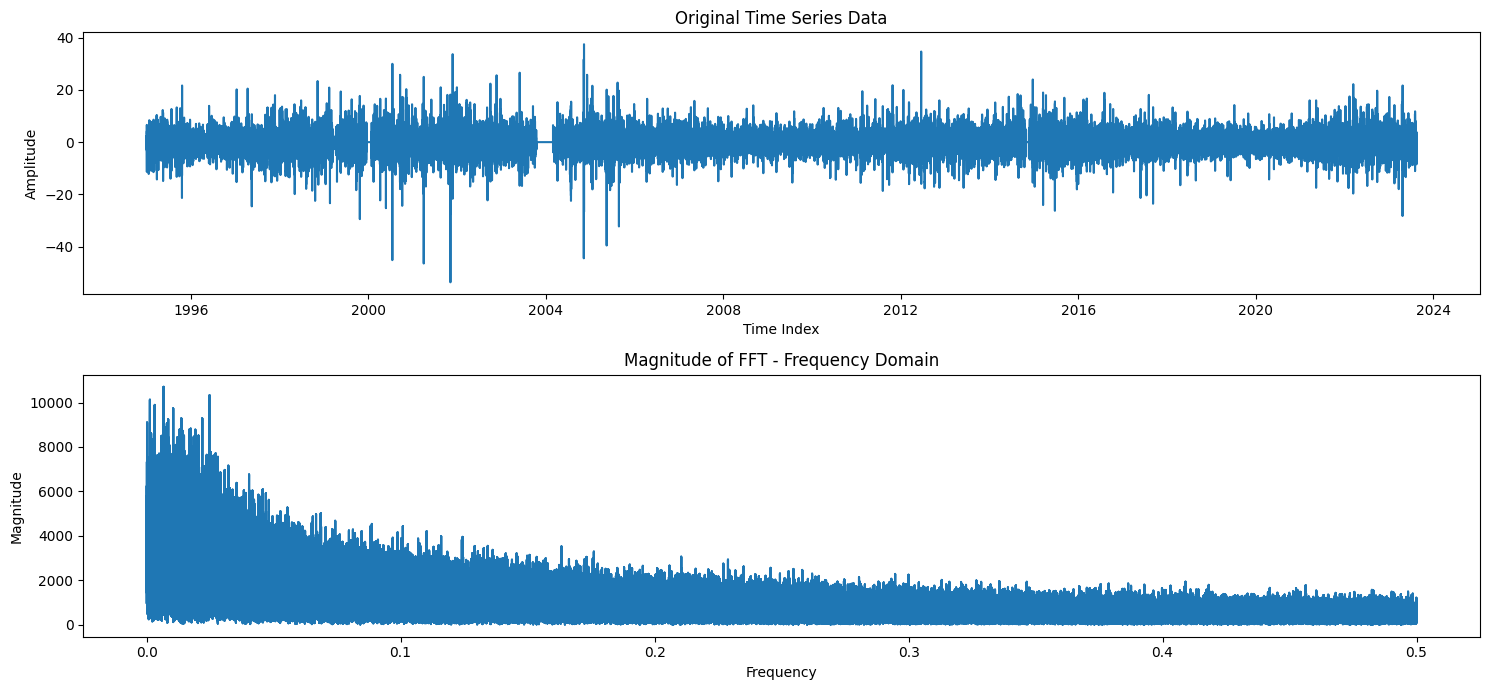

In [15]:
fft_vals = np.fft.fft(df["WIND Bz_gse, nT"])

fft_freq = np.fft.fftfreq(len(fft_vals))# Corresponding frequencies


plt.figure(figsize=(15, 7))

plt.subplot(2, 1, 1)
plt.plot(df["WIND Bz_gse, nT"])
plt.title('Original Time Series Data')
plt.xlabel('Time Index')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(np.abs(fft_freq), np.abs(fft_vals))
plt.title('Magnitude of FFT - Frequency Domain')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()


# THresholding

In [16]:
df2 = df.copy()

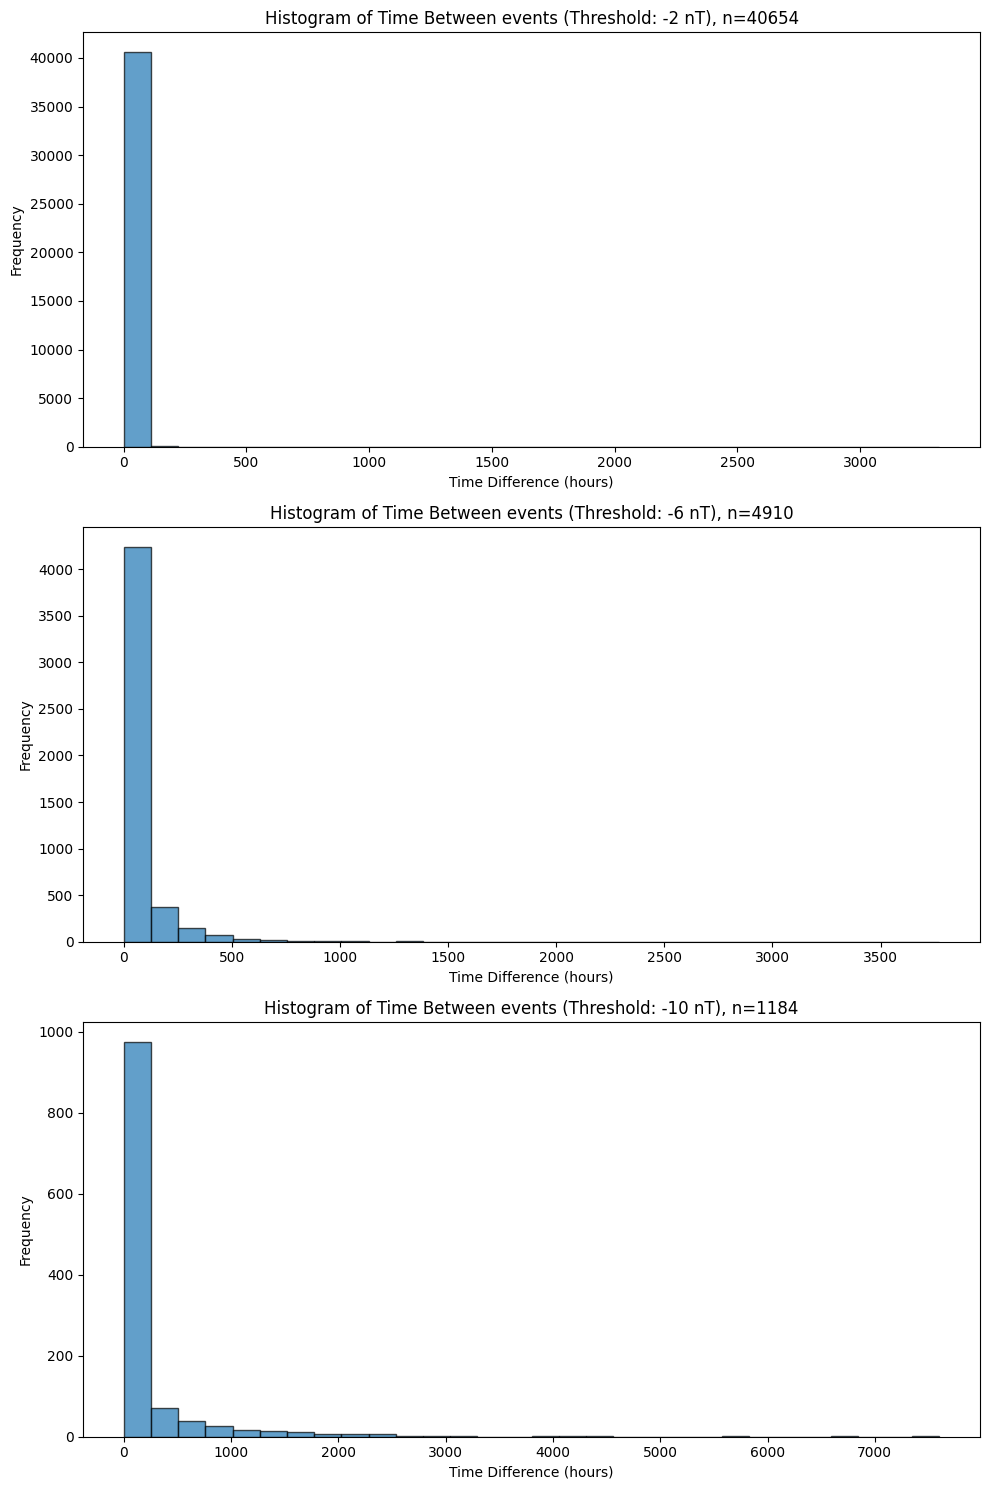

In [17]:
thresholds = [-2, -6, -10] #in nT

fig, axs = plt.subplots(len(thresholds), figsize=(10, 5*len(thresholds)))
for i, threshold in enumerate(thresholds):
    WIND_IMF_times = df2.index[ df2["WIND Bz_gse, nT"] <= threshold]
    WIND_IMF_time_diffs = WIND_IMF_times[1:] - WIND_IMF_times[:-1]
    # print("Number of IMF below {threshold} nT threshold: ", len(DSCOV_IMF_time_diffs))

    WIND_IMF_time_diffs_hrs = WIND_IMF_time_diffs.total_seconds() / 3600  
    axs[i].hist(WIND_IMF_time_diffs_hrs, bins=30, edgecolor='k', alpha=0.7)
    axs[i].set_title(f'Histogram of Time Between events (Threshold: {threshold} nT), n={len(WIND_IMF_time_diffs)}')
    axs[i].set_xlabel('Time Difference (hours)')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [19]:
# Creating the new dataset for event/noevent
for threshold in thresholds:
    df[f'z_binary_{threshold}'] = (df["WIND Bz_gse, nT"] <= threshold).astype(int)

In [20]:
df.head()

,Year,Day,Hour,"WIND Bx_gse, nT","WIND By_gse, nT","WIND Bz_gse, nT",z_binary_-2,z_binary_-6,z_binary_-10
Date-Time,,,,,,,,,
1995-01-01 00:00:00,1995,1,0,-0.6,3.2,-2.1,1,0,0
1995-01-01 01:00:00,1995,1,1,-0.9,2.4,-1.3,0,0,0
1995-01-01 02:00:00,1995,1,2,0.5,1.8,-0.4,0,0,0
1995-01-01 03:00:00,1995,1,3,-3.2,2.5,0.3,0,0,0
1995-01-01 04:00:00,1995,1,4,-4.3,2.1,0.3,0,0,0


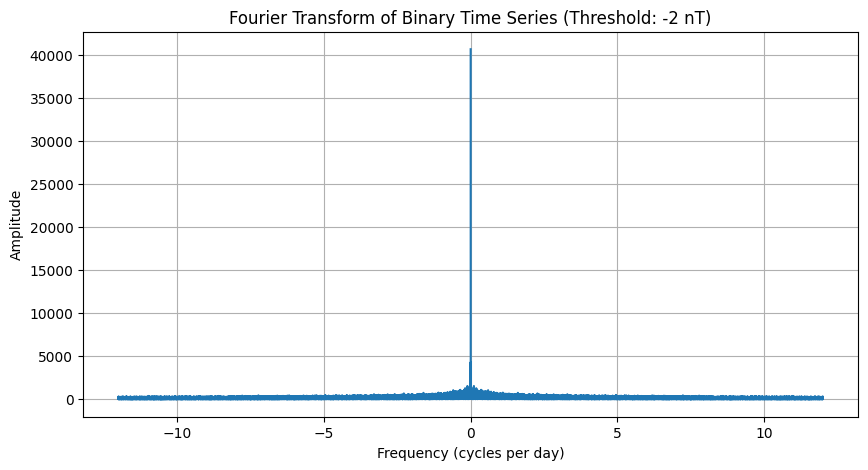

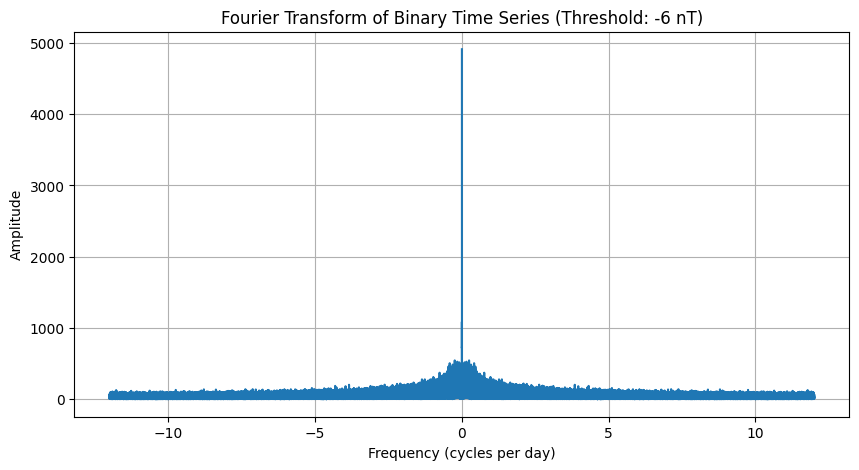

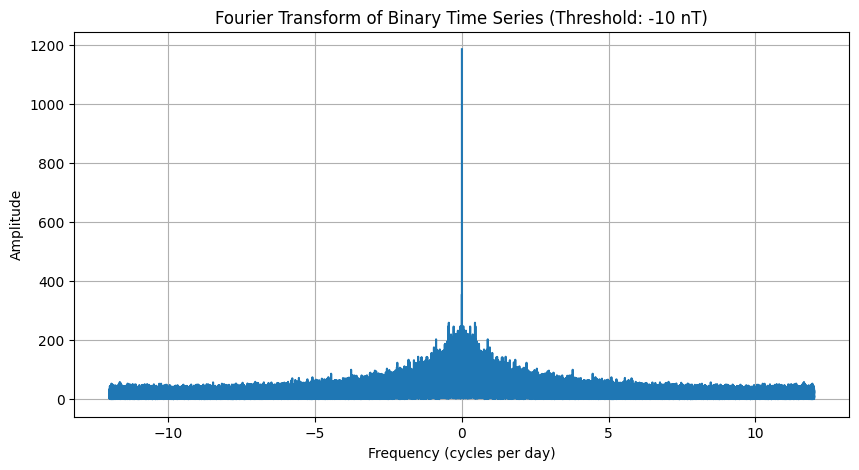

In [23]:
for chosen_threshold in thresholds:
    binary_series = df[f'z_binary_{chosen_threshold}']

    TIME_SPACING = 1/24
    fft_vals = np.fft.fft(binary_series)
    fft_freq = np.fft.fftfreq(len(fft_vals), d=TIME_SPACING)

    plt.figure(figsize=(10, 5))
    plt.plot(fft_freq, np.abs(fft_vals))
    plt.title(f'Fourier Transform of Binary Time Series (Threshold: {chosen_threshold} nT)')
    plt.xlabel('Frequency (cycles per day)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

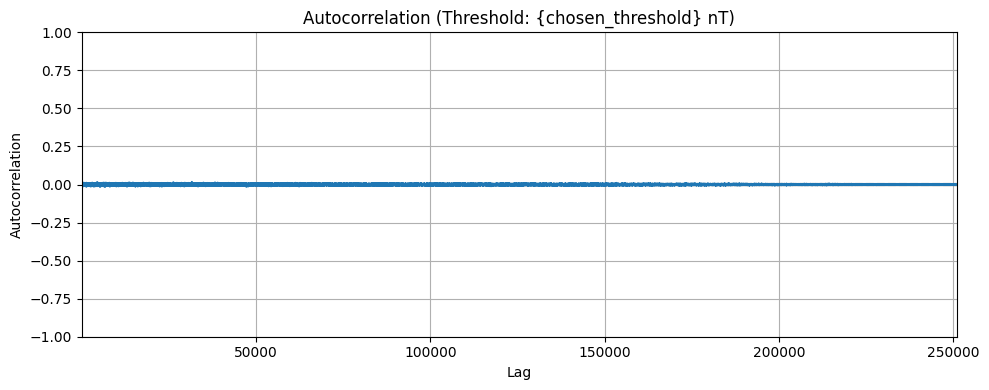

In [26]:
binary_series = df['WIND Bz_gse, nT']
plt.figure(figsize=(10, 4))
autocorrelation_plot(binary_series)
plt.title('Autocorrelation (Threshold: {chosen_threshold} nT)')
plt.tight_layout()
plt.show()

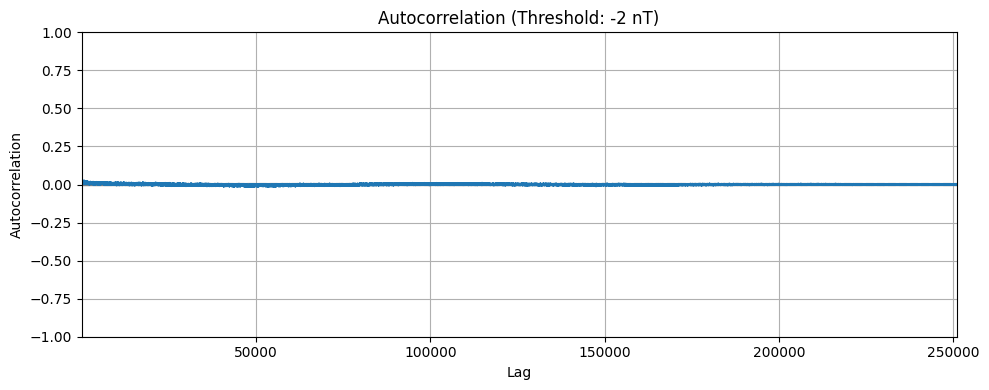

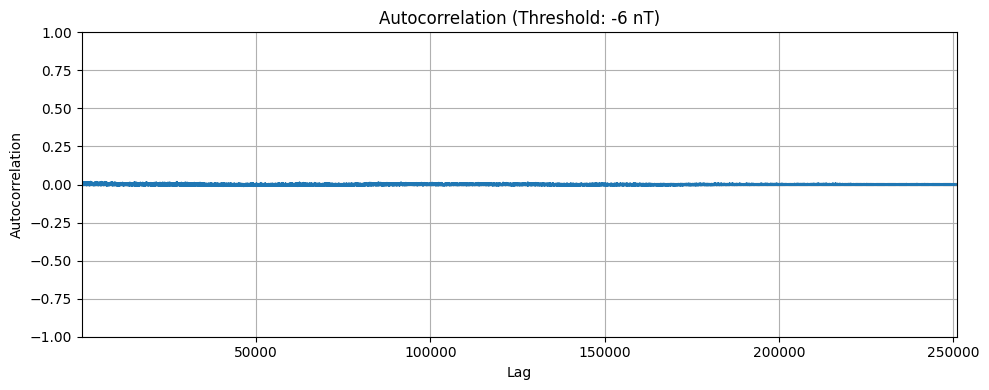

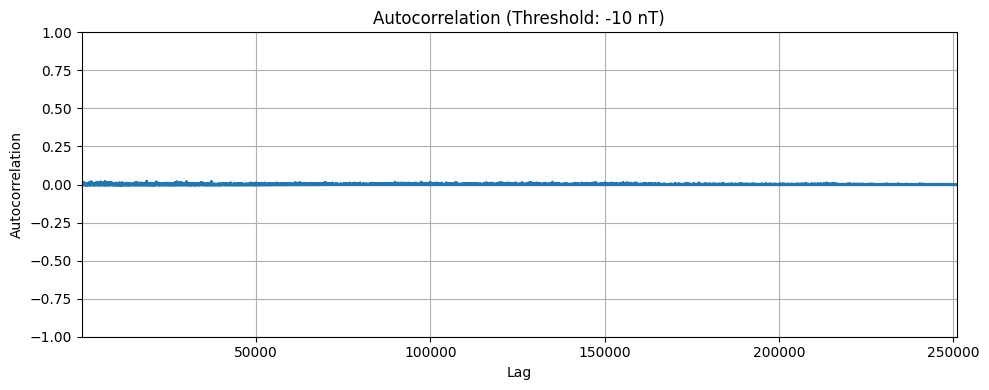

In [27]:
for chosen_threshold in thresholds:
    binary_series = df[f'z_binary_{chosen_threshold}']
    plt.figure(figsize=(10, 4))
    autocorrelation_plot(binary_series)
    plt.title(f'Autocorrelation (Threshold: {chosen_threshold} nT)')
    plt.tight_layout()
    plt.show()
